In [2]:
import os
import glob
import time
import torch
import cv2
from PIL import Image
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

# See github.com/timesler/facenet-pytorch:
from facenet_pytorch import MTCNN, InceptionResnetV1, extract_face

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Running on device: {device}')

C:\Users\xin chao\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running on device: cpu


In [3]:
# Load face detector
mtcnn = MTCNN(margin=14, keep_all=True, factor=0.5, device=device).eval()

# Load facial recognition model
resnet = InceptionResnetV1(pretrained='vggface2', device=device).eval()

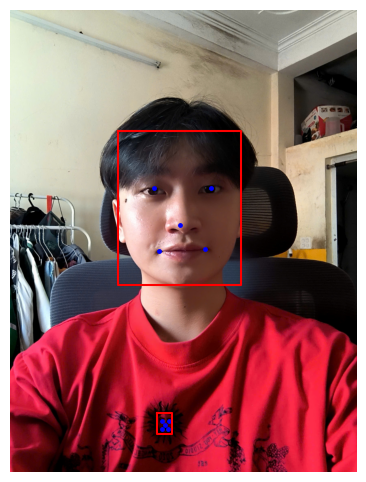

In [4]:
# Load ảnh
image = Image.open('./Database/Hieu/1.jpg')  # Thay đường dẫn ảnh ở đây

# Phát hiện khuôn mặt và landmarks
boxes, probs, landmarks = mtcnn.detect(image, landmarks=True)

# Hiển thị kết quả
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')

# Vẽ bounding boxes và landmarks
if boxes is not None:
    for box, landmark in zip(boxes, landmarks):
        # Vẽ khung
        x0, y0, x1, y1 = box
        plt.plot([x0, x1, x1, x0, x0], [y0, y0, y1, y1, y0], color='r')
        # Vẽ landmark
        plt.scatter(landmark[:, 0], landmark[:, 1], s=6, c='blue')

plt.show()

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

mtcnn = MTCNN(keep_all=False, device=device)
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

In [17]:
import albumentations as A

augmentation = A.Compose([
            A.Rotate(limit=15, p=0.5),  # Xoay ±15 độ
            A.HorizontalFlip(p=0.5),  # Lật ngang
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=15, p=0.5),
            A.GaussNoise(p=0.2),  
        ])

C:\Users\xin chao\AppData\Roaming\Python\Python310\site-packages\albumentations\core\validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [73]:
def extract_embeddings(image_path, num_augmentations=8):
    # Load and process the original image
    img = Image.open(image_path).convert('RGB')  # Ensure image is in RGB format
    img_cropped = mtcnn(img)
    if img_cropped is None:
        return None
    
    # List to store embeddings (original + augmented)
    embeddings = []
    
    # Process original image
    img_cropped = img_cropped.unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = resnet(img_cropped).cpu().numpy()
    embeddings.append(embedding.flatten())
    
    # Convert PIL image to format compatible with augmentation (e.g., numpy array)
    img_np = np.array(img)
    
    # Apply augmentations
    for _ in range(num_augmentations):
        # Apply augmentation
        augmented = augmentation(image=img_np)['image']
        
        # Convert augmented image back to PIL for MTCNN
        aug_img = Image.fromarray(augmented)
        
        # Process augmented image
        aug_cropped = mtcnn(aug_img)
        if aug_cropped is None:
            continue  # Skip if MTCNN fails to detect face
        
        aug_cropped = aug_cropped.unsqueeze(0).to(device)
        with torch.no_grad():
            aug_embedding = resnet(aug_cropped).cpu().numpy()
        embeddings.append(aug_embedding.flatten())
    
    return embeddings if embeddings else None

In [74]:
def load_dataset(dataset_path, num_augmentations=8):
    embeddings = []
    labels = []
    for person_name in os.listdir(dataset_path):
        person_dir = os.path.join(dataset_path, person_name)
        if not os.path.isdir(person_dir):
            continue
        for image_name in os.listdir(person_dir):
            image_path = os.path.join(person_dir, image_name)
            print(f'Processing {image_path}')
            image_embeddings = extract_embeddings(image_path, num_augmentations)
            if image_embeddings is not None:
                # Add all embeddings (original + augmented) and corresponding labels
                embeddings.extend(image_embeddings)
                labels.extend([person_name] * len(image_embeddings))
    return np.array(embeddings), np.array(labels)

In [75]:
# Hàm dự đoán với kiểm tra "unknown"
def predict_face(knn, image_path, threshold=0.7):
    embedding = extract_embeddings(image_path)
    if embedding is None:
        return "No face detected"
    distances, indices = knn.kneighbors([embedding])
    min_distance = distances[0][0]
    print(f"Min distance: {min_distance}")
    if min_distance <= threshold:
        prediction = knn.predict([embedding])[0]
        return prediction
    else:
        return "unknown"

In [76]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

dataset_path = 'Database'
X, y = load_dataset(dataset_path, 8)

Processing Database\Hiep\1.jpg
Processing Database\Hiep\2.jpg
Processing Database\Hiep\3.jpg
Processing Database\Hiep\4.jpg
Processing Database\Hieu\1.jpg
Processing Database\Hieu\2.jpg
Processing Database\Hieu\3.jpg
Processing Database\Hieu\4.jpg
Processing Database\Ishikawa\1.jpg
Processing Database\Ishikawa\2.jpg
Processing Database\Ishikawa\3.jpg
Processing Database\Ishikawa\4.jpg
Processing Database\Nishida\1.jpg
Processing Database\Nishida\2.jpg
Processing Database\Nishida\3.jpg
Processing Database\Nishida\4.jpg
Processing Database\Ronaldo\1.jpg
Processing Database\Ronaldo\10.jpg
Processing Database\Ronaldo\2.jpg
Processing Database\Ronaldo\4.jpg
Processing Database\Ronaldo\5.jpg
Processing Database\Ronaldo\6.jpg
Processing Database\Ronaldo\7.jpg
Processing Database\Ronaldo\9.jpg
Processing Database\Sekita\1.jpg
Processing Database\Sekita\2.jpg
Processing Database\Sekita\3.jpg


In [77]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  
)

In [78]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [82]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

cv_scores = []
k_range = range(3, int(len(X_train) ** 0.5), 2)  # thường <= sqrt(n_samples)

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='accuracy')  # cross-validation
    print(f'k = {k}, CV accuracy = {scores.mean()}')
    cv_scores.append(scores.mean())

best_k = k_range[np.argmax(cv_scores)]
print(f'Best k = {best_k}')

k = 3, CV accuracy = 0.968960863697706
k = 5, CV accuracy = 0.968960863697706
k = 7, CV accuracy = 0.963697705802969
k = 9, CV accuracy = 0.963697705802969
k = 11, CV accuracy = 0.963697705802969
Best k = 3


Text(0.5, 1.0, 'Cross-validation accuracy vs. k')

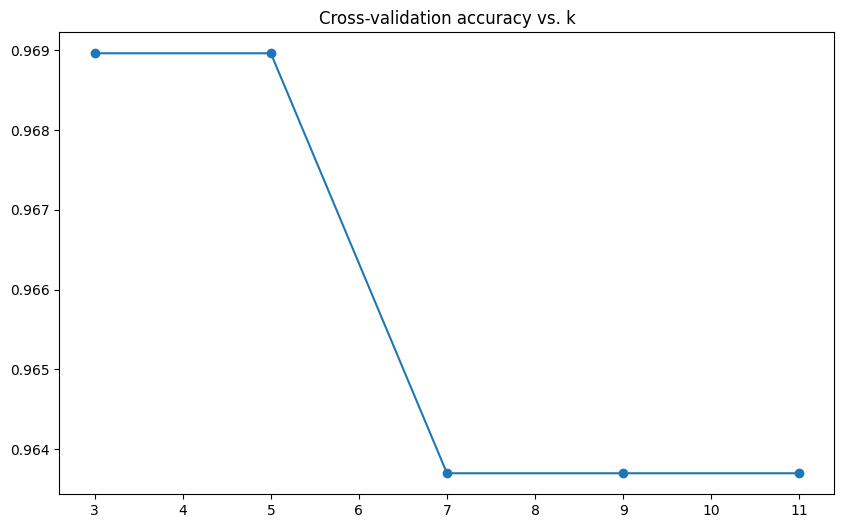

In [83]:
# Draw
plt.figure(figsize=(10, 6))
plt.plot(k_range, cv_scores, marker='o')
plt.title('Cross-validation accuracy vs. k')

Accuracy: 1.00
              precision    recall  f1-score   support

        Hiep       1.00      1.00      1.00         7
        Hieu       1.00      1.00      1.00         7
    Ishikawa       1.00      1.00      1.00         7
     Nishida       1.00      1.00      1.00         7
     Ronaldo       1.00      1.00      1.00        15
      Sekita       1.00      1.00      1.00         5

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48



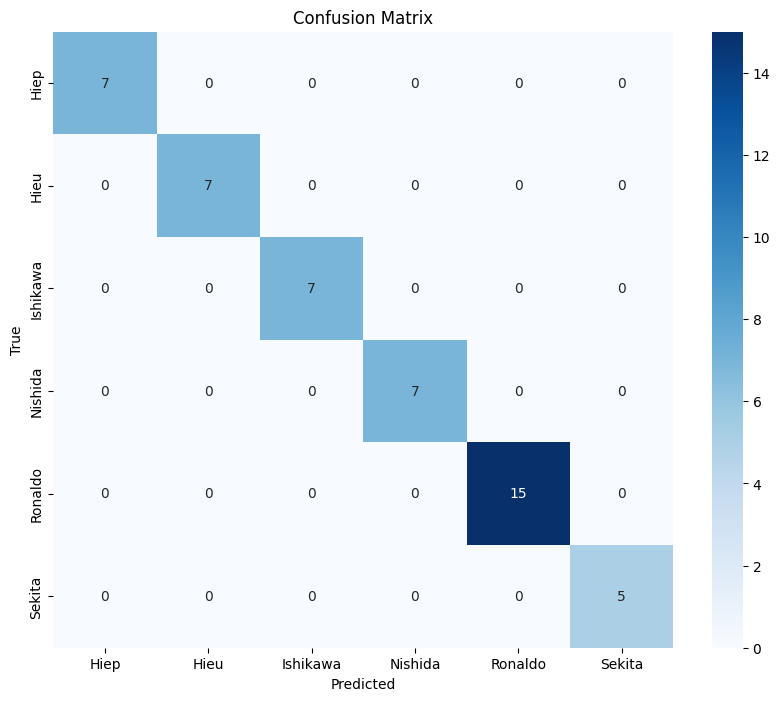

In [84]:
knn = KNeighborsClassifier(n_neighbors=best_k, metric='euclidean')
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score

print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
print(classification_report(y_test, y_pred, target_names=np.unique(y_train)))
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_train))
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
